## CS Algorithm, bringing it all together

### Try to recover product measurement matrix using SVD
### (product of transform matrix that turns signal sparse and random matrix)

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from numpy.fft import fft, ifft

In [2]:
# Set params
nt = 200 # num of time points
nf = 16 # num of fibers
nph= 180 # num of phases

tmax = 4.5e-9 #end time
tmin = 1e-9 # start time
dt = (tmax - tmin) / nt

In [3]:
# Use lasso method with this 16x200 matrix-which is the random matrix * DFT matrix to recover I and Q for signal from measurement matrix

# Recover a signal
def recover(y, m):
    pf = 1e-4
    def fun(x, A = m, y = y, pf = pf) : 
        return np.square(np.linalg.norm(np.dot(A, x) - y)) + .5*pf*np.linalg.norm(x, ord = 1)
    return minimize(fun, x0 = np.zeros(nt)).x

In [4]:
# Calibration for each freq on time grid, take freq and mult by random matrix
A = norm.rvs(size = (nf,nt)) # set random matrix

t = np.linspace(tmin, tmax, nt) # time series for input into sinusoids
freqs = np.linspace(1/(tmax-tmin), 2/dt, int(nt/2)) # freq series, from time grid (100 freqs), time-wavelength mapping

# Create appropriate size array with copies of t
calib = np.zeros((nph,nt))
calib[:] = t
# Initialize ip and q
ip = np.array([])
q = np.array([])

# Begin frequency sweep through dictionary
for f in freqs:
#      Use sine waves as signal 
#      vector is 200x1, sampled sine wave. There are nph different phases for each frequency
    ts = np.cos(2*np.pi*f*calib + np.random.uniform(0, 2*np.pi, size = (nph, 1)))
#      Sparsify using a transform, such as DFT. Use freqs on a grid to get better results in sparsification (single point in DfT, test with signals on grid for calibration)
#      vector is 200x1, but mostly 0s
    fs = fft(ts)
#      Multiply sparse vector with random wide matrix
#      Matrix is 16x200 so result becomes 16x1
    y = np.dot(A, fs.T)
#      Do this for 180 different random phases (can do more or fewer, will get I and Q, to get 16x180 matrix
#      Use these (16x180 matrix) in SVD to get in-phase and quadrature comp for each freq
    u, s, v = np.linalg.svd(y)

    ip = np.vstack([ip, u[0]]) if ip.size else u[0]
    q = np.vstack([q, u[1]]) if q.size else u[1]
    
# Now create 16x(2*100) matrix composed of I and Q vectors

m = np.vstack([ip,q]).T


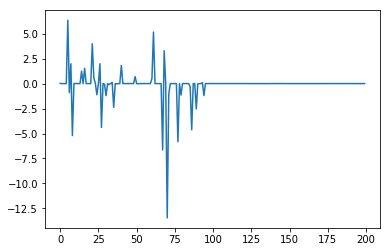

In [5]:
# Scramble an x
ytest = recover(np.dot(A, np.cos(2*np.pi*2e9*t)), m)
plt.plot(ytest)
I = ytest[0:100]
Q = ytest[100:200]

amp = np.sqrt(np.square(I) + np.square(Q)) 
phi = np.arctan(np.divide(Q, I))

signals = np.array([])
for idx, f in enumerate(freqs): 
    signal = amp[idx]*np.cos(2*np.pi*f*t + phi[idx])
    signals = np.vstack([signals, signal]) if signals.size else signal
                

# Gauge accuracy by comparing recovery to original signal

(200,)


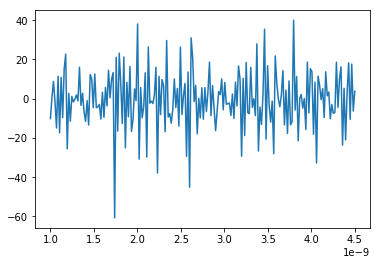

In [6]:
signal = np.sum(signals, axis = 0)
print(np.shape(signal))
plt.plot(t,  signal)
plt.show()